<a href="https://colab.research.google.com/github/Vikash-exe/Computer-Vision/blob/main/U_Net_tuning_Vikash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# model = build_unet_resnet50(input_shape=(256, 256, 3), num_classes=7)

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# #model.summary()


In [ ]:
# ✅ STEP 1: Mount Google Drive and Unzip Dataset
from zipfile import ZipFile
import os

from google.colab import drive
drive.mount('/content/drive')

# Paths to your uploaded dataset zip file
zip_path = "/content/drive/MyDrive/Dataset.zip"  # Update if needed
extract_path = "/content/dataset"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [ ]:
image_dir = os.path.join(extract_path, "images")
mask_dir = os.path.join(extract_path, "masks")

image_dir = "/content/dataset/images"
mask_dir = "/content/dataset/masks"

In [ ]:
# !ls /content/dataset
# !ls /content/dataset/images
# !ls /content/dataset/masks


Dataset loading and **preprocessing**

80-20 split

In [ ]:
# ✅ STEP 3: Define Preprocessing Functions
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

IMG_SIZE = 256
NUM_CLASSES = 8

category_colors = {
    1: (255, 0, 0),      # BUILTUP
    2: (255, 255, 0),    # VACANT LAND
    3: (0, 0, 255),      # WATER
    4: (128, 64, 128),   # ROAD
    5: (64, 0, 128),     # SHADOW
    6: (128, 0, 0),      # PAVED AREAS
    7: (0, 255, 0),      # VEGETATION
    8: (255, 255, 255)   # OTHERS
}

def load_images_and_masks(img_dir, mask_dir, limit=None):
    X, y = [], []
    image_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    if limit:
        image_files = image_files[:limit]
        mask_files = mask_files[:limit]

    for img_name, mask_name in zip(image_files, mask_files):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        X.append(image)
        y.append(mask)

    return np.array(X), np.array(y)

In [ ]:
# ✅ STEP 4: Load Data (Limited to 1000 to avoid RAM crash)
X, y = load_images_and_masks(image_dir, mask_dir, limit=1000)
print("✅ Loaded:", X.shape, y.shape)

# ✅ STEP 5: One-Hot Encode the Masks
def one_hot_encode_masks(masks):
    encoded = np.zeros((masks.shape[0], IMG_SIZE, IMG_SIZE, NUM_CLASSES), dtype=np.uint8)
    for i in range(NUM_CLASSES):

        encoded[..., i] = (masks == (i)).astype(np.uint8)
    return encoded

y_encoded = one_hot_encode_masks(y)

✅ Loaded: (500, 256, 256, 3) (500, 256, 256)


To define file variables

train and split

In [ ]:
# ✅ STEP 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

# Add preprocessing step: Normalize image data to [0, 1]
# The original variable names X_train_prep and X_test_prep are used to match the fit call
X_train_prep = X_train.astype('float32') / 255.0
X_test_prep = X_test.astype('float32') / 255.0

Train size: (400, 256, 256, 3) (400, 256, 256, 8)
Test size: (100, 256, 256, 3) (100, 256, 256, 8)


In [ ]:
!pip uninstall -y efficientnet image-classifiers
!pip install -q segmentation-models==1.0.1 efficientnet==1.0.0 image-classifiers==1.0.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install -q segmentation-models==1.0.1 efficientnet==1.0.0 image-classifiers==1.0.0


In [ ]:
y = y - 1  # now mask values are from 0 to 7


In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input
X = preprocess_input(X)


Detailed_Model using ResNet50 bacbone in U-Net architecture

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_unet_resnet50(input_shape=(256, 256, 3), num_classes=8):
    # -------- Encoder: ResNet50 -------- #
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Feature maps to use as skip connections
    skip1 = base_model.get_layer("conv1_relu").output        # 128 x 128 x 64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 64 x 64 x 256
    skip3 = base_model.get_layer("conv3_block4_out").output  # 32 x 32 x 512
    skip4 = base_model.get_layer("conv4_block6_out").output  # 16 x 16 x 1024

    bottleneck = base_model.get_layer("conv5_block3_out").output  # 8 x 8 x 2048

    # -------- Decoder: U-Net-style upsampling -------- #
    x = bottleneck  # 8x8x2048

    x = layers.UpSampling2D((2, 2))(x)        # 16 x 16 x 2048
    x = layers.Concatenate()([x, skip4])      # 16 x 16 x 3072
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 32 x 32 x 256
    x = layers.Concatenate()([x, skip3])      # 32 x 32 x 768
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 64 x 64 x 256
    x = layers.Concatenate()([x, skip2])      # 64 x 64 x 512
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 128 x 128 x 256
    x = layers.Concatenate()([x, skip1])      # 128 x 128 x 320
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 256 x 256 x 256
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # -------- Output Layer -------- #
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return models.Model(inputs=base_model.input, outputs=output)


Compiling the model

In [ ]:
import tensorflow as tf

def fast_categorical_crossentropy(y_true, y_pred):
    """
    y_true: one-hot encoded masks [B, H, W, C]
    y_pred: softmax outputs from model [B, H, W, C]
    """
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)  # Avoid log(0)
    return tf.reduce_mean(tf.reduce_sum(-y_true * tf.math.log(y_pred), axis=-1))


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Works with one-hot masks and softmax outputs.
    """
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice)


In [ ]:
def combined_loss(y_true, y_pred):
    ce = fast_categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice


In [ ]:
model = build_unet_resnet50()
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("✅ GPU is available!")
    for gpu in gpus:
        print("GPU:", gpu.name)
else:
    print("❌ GPU is NOT available. Using CPU instead.")


✅ GPU is available!
GPU: /physical_device:GPU:0


training--

In [ ]:
# ✅ STEP 8: Train the Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train_prep, y_train,
    validation_data=(X_test_prep, y_test),
    epochs=25,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5578 - loss: 2.1741 - val_accuracy: 0.0057 - val_loss: 16.9275
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 483ms/step - accuracy: 0.7039 - loss: 1.4116 - val_accuracy: 1.6266e-04 - val_loss: 16.9578
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.6961 - loss: 1.4211 - val_accuracy: 0.3123 - val_loss: 5.7038
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.7190 - loss: 1.3348 - val_accuracy: 0.0831 - val_loss: 6.2618
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - accuracy: 0.7171 - loss: 1.2932 - val_accuracy: 0.0140 - val_loss: 16.5785
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 483ms/step - accuracy: 0.7344 - loss: 1.2180 - val_accuracy: 0.2604 - val_loss: 4.7624
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - accuracy: 0.7498 - loss: 1.1753 - val_accuracy: 0.2466 - val_loss: 5.3017
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 496ms/step - accuracy: 0.7659 - loss: 1.1139 - val

plotting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


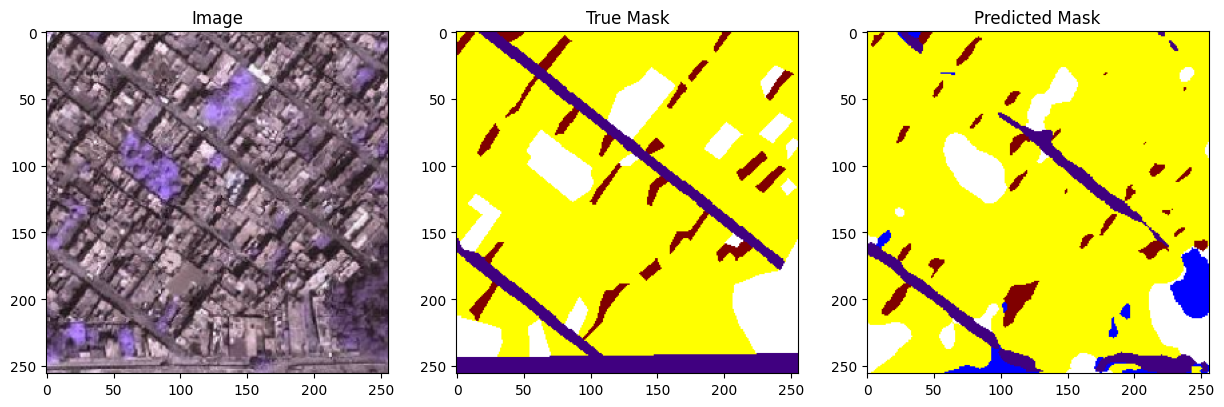

In [ ]:
# ✅ STEP 9: Visualize Predictions
import matplotlib.pyplot as plt

def decode_segmentation(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in category_colors.items():
        color_mask[mask == class_id] = color
    return color_mask

# Show prediction
sample_idx = 4
pred_mask = model.predict(np.expand_dims(X_test_prep[sample_idx], axis=0))
pred_mask = np.argmax(pred_mask.squeeze(), axis=-1) + 1

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(X_test[sample_idx])

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(decode_segmentation(np.argmax(y_test[sample_idx], axis=-1) + 1))

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(decode_segmentation(pred_mask))
plt.show()


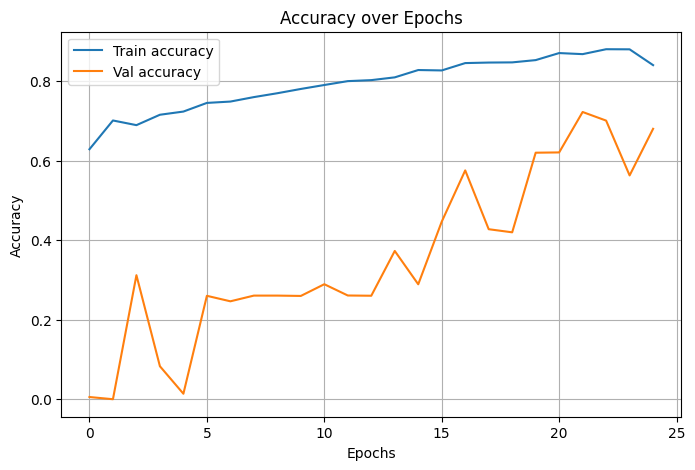

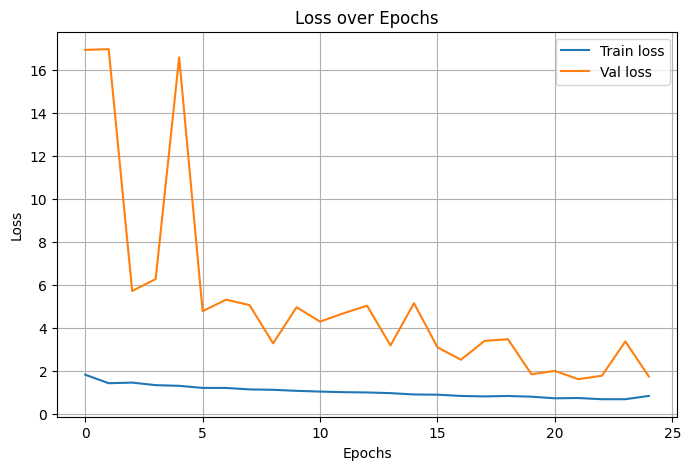

In [ ]:
# ✅ STEP 9: Plot Training Curves (Loss, Accuracy, etc.)
def plot_training_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]  # e.g. ['loss', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history[metric], label='Train ' + metric)
        plt.plot(history.history['val_' + metric], label='Val ' + metric)
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training_history(history)


In [ ]:
# ✅ STEP 10: Save the Model
model_save_path = '/content/drive/MyDrive/unet_resnet50_tune1_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/unet_resnet50_tune1_model.h5


For F score and Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000     67772
           1      0.843     0.762     0.800   1528336
           2      0.559     0.865     0.679   1709899
           3      0.872     0.595     0.707    146871
           4      0.785     0.336     0.471    431284
           5      0.753     0.207     0.325    227489
           7      0.833     0.743     0.785   2441949

    accuracy                          0.723   6553600
   macro avg      0.664     0.501     0.538   6553600
weighted avg      0.750     0.723     0.715   6553600



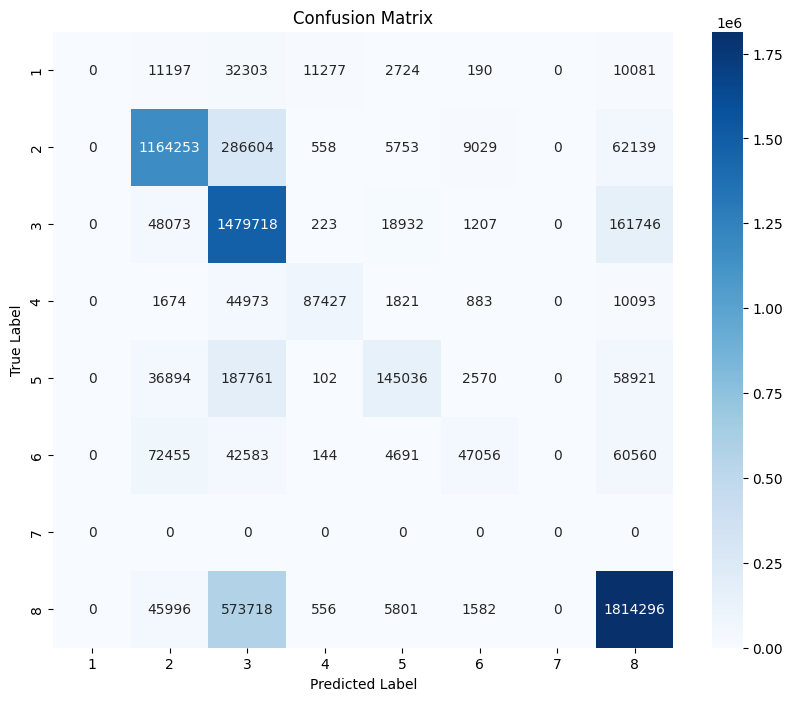

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns

# Choose how many samples to evaluate
num_samples = 100  # Adjust if needed
y_true_all = []
y_pred_all = []

for i in range(num_samples):
    img = np.expand_dims(X_test_prep[i], axis=0)
    pred = model.predict(img)

    pred_label = np.argmax(pred.squeeze(), axis=-1).flatten()
    true_label = np.argmax(y_test[i], axis=-1).flatten()

    y_pred_all.extend(pred_label)
    y_true_all.extend(true_label)

# ✅ F1 Score (Macro, Weighted, etc.)
print("F1 Score (macro):", f1_score(y_true_all, y_pred_all, average='macro'))
print("F1 Score (weighted):", f1_score(y_true_all, y_pred_all, average='weighted'))

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, digits=3))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=np.arange(NUM_CLASSES))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(category_colors.keys()),
            yticklabels=list(category_colors.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
